In [391]:
from pyspark.sql import SparkSession, DataFrame

In [392]:
# Initializes Spark session with MongoDB connector
jar_files_path = "file:///C:/Users/llucp/spark_jars/"

jar_files = [
    "mongo-spark-connector_2.12-10.1.1.jar",
    "mongodb-driver-core-4.10.1.jar",
    "mongodb-driver-sync-4.10.1.jar",
    "bson-4.10.1.jar"
]

MONGO_URI = "mongodb://127.0.0.1:27017/"
DB_NAME = "tfg"
STANDARD_LOB_COLLECTION = "standard_lob"

spark = (
    SparkSession.builder
    .appName("FeaturesAnalysis")
    .config("spark.jars", ",".join([jar_files_path + jar for jar in jar_files]))
    .config("spark.mongodb.read.connection.uri", MONGO_URI)
    .config("spark.mongodb.write.connection.uri", MONGO_URI)
    .config("spark.mongodb.read.database", DB_NAME)
    .config("spark.mongodb.write.database", DB_NAME)
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

In [393]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import re

In [394]:
def load_lob() -> DataFrame:
    """
    Loads Landing Zone LOB data and returns it as a dataframe.
    """
    lob = (
        spark.read.format("mongodb")
        .option("database", DB_NAME)
        .option("collection", STANDARD_LOB_COLLECTION)
        .load()
    )

    return lob

In [395]:
lob = load_lob()
cols = ["depth_all", "depth_imbalance_all", "depth_imbalance_top_15", "depth_imbalance_top_5", "depth_imbalance_top_50", "depth_top_15", "depth_top_5", "depth_top_50", "liquidity_concentration_all", "liquidity_concentration_top_15", "liquidity_concentration_top_5", "liquidity_concentration_top_50", "liquidity_spread_all", "liquidity_spread_top_15", "liquidity_spread_top_5", "liquidity_spread_top_50", "microprice", "mid_price", "price_impact_proxy_all", "price_impact_proxy_top_15", "price_impact_proxy_top_5", "price_impact_proxy_top_50", "spread", "volatility", "fwd_logret_2", "fwd_logret_3", "fwd_logret_4", "fwd_logret_5", "fwd_logret_10", "fwd_logret_20", "fwd_logret_40", "fwd_logret_60", "fwd_logret_120", "fwd_logret_240"]
df = lob.select(cols).dropna().toPandas()
df.head()

,depth_all,depth_imbalance_all,depth_imbalance_top_15,depth_imbalance_top_5,depth_imbalance_top_50,depth_top_15,depth_top_5,depth_top_50,liquidity_concentration_all,liquidity_concentration_top_15,...,fwd_logret_2,fwd_logret_3,fwd_logret_4,fwd_logret_5,fwd_logret_10,fwd_logret_20,fwd_logret_40,fwd_logret_60,fwd_logret_120,fwd_logret_240
0,264049700.0,0.192848,-0.223394,0.286807,-0.035508,1090900.0,418400.0,6314000.0,1.0,0.004131,...,0.000154,-0.000020,-0.000200,0.000343,-0.000311,0.000183,0.001054,0.001260,0.000612,-0.002180
1,265676200.0,0.193167,-0.180778,-0.063771,-0.014116,996800.0,290100.0,6531600.0,1.0,0.003752,...,-0.000174,-0.000354,0.000190,0.000035,-0.000613,-0.000062,0.001104,0.001007,0.000458,-0.001980
2,264366400.0,0.191142,-0.257170,-0.275648,-0.025019,1039000.0,193000.0,6215300.0,1.0,0.003930,...,-0.000354,0.000190,0.000035,-0.000429,-0.000265,-0.000143,0.001127,0.001007,0.000458,-0.001131
3,265019600.0,0.195926,-0.274225,0.111871,-0.028504,910200.0,292300.0,5999200.0,1.0,0.003434,...,0.000364,0.000209,-0.000255,-0.000112,0.000195,0.000202,0.001210,0.001181,0.000429,-0.001403
4,263792400.0,0.192829,-0.186822,0.343260,-0.025602,783100.0,248500.0,6003500.0,1.0,0.002969,...,0.000388,-0.000075,0.000068,-0.000114,0.000692,0.000382,0.001382,0.001360,0.000744,-0.001047


In [396]:
features = ["depth_all","depth_imbalance_all","depth_imbalance_top_15","depth_imbalance_top_5","depth_imbalance_top_50","depth_top_15","depth_top_5","depth_top_50","liquidity_concentration_top_15","liquidity_concentration_top_5","liquidity_concentration_top_50","liquidity_spread_all","liquidity_spread_top_15","liquidity_spread_top_5","liquidity_spread_top_50","microprice","mid_price","price_impact_proxy_all","price_impact_proxy_top_15","price_impact_proxy_top_5","price_impact_proxy_top_50","volatility"]
X = df[features]
X.head()

,depth_all,depth_imbalance_all,depth_imbalance_top_15,depth_imbalance_top_5,depth_imbalance_top_50,depth_top_15,depth_top_5,depth_top_50,liquidity_concentration_top_15,liquidity_concentration_top_5,...,liquidity_spread_top_15,liquidity_spread_top_5,liquidity_spread_top_50,microprice,mid_price,price_impact_proxy_all,price_impact_proxy_top_15,price_impact_proxy_top_5,price_impact_proxy_top_50,volatility
0,264049700.0,0.192848,-0.223394,0.286807,-0.035508,1090900.0,418400.0,6314000.0,0.004131,0.001585,...,18.677633,6.948446,58.555833,109181.758208,109181.75,0.012123,0.000033,0.000039,0.000016,0.000237
1,265676200.0,0.193167,-0.180778,-0.063771,-0.014116,996800.0,290100.0,6531600.0,0.003752,0.001092,...,24.265560,7.149052,58.815679,109180.007756,109180.05,0.012049,0.000041,0.000044,0.000015,0.000232
2,264366400.0,0.191142,-0.257170,-0.275648,-0.025019,1039000.0,193000.0,6215300.0,0.003930,0.000730,...,17.095053,0.904249,57.378822,109196.887231,109196.85,0.012108,0.000032,0.000063,0.000016,0.000230
3,265019600.0,0.195926,-0.274225,0.111871,-0.028504,910200.0,292300.0,5999200.0,0.003434,0.001103,...,19.545737,3.007663,61.364739,109196.855808,109196.85,0.012078,0.000038,0.000039,0.000018,0.000226
4,263792400.0,0.192829,-0.186822,0.343260,-0.025602,783100.0,248500.0,6003500.0,0.002969,0.000942,...,20.619436,6.119437,60.905167,109177.801811,109177.85,0.012135,0.000050,0.000064,0.000016,0.000225


In [397]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_arch

In [398]:
def _safe_series(x):
    s = pd.Series(x).astype(float)
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    return s

In [399]:
def analyze_feature(series, name, arch_lags=12):
    s = _safe_series(series)
    n = int(s.size)
    miss = int(pd.isna(series).sum())
    uniq = int(pd.Series(series).nunique(dropna=True))
    is_const = (n == 0) or (s.nunique() <= 1)

    # Summary stats
    summary = {
        "feature": name,
        "n": n,
        "missing": miss,
        "unique": uniq,
        "is_constant": bool(is_const),
        "mean": np.nan if n==0 else float(s.mean()),
        "std": np.nan if n==0 else float(s.std(ddof=1)),
        "skew": np.nan if n==0 else float(stats.skew(s, bias=False)),
        "kurtosis_excess": np.nan if n==0 else float(stats.kurtosis(s, fisher=True, bias=False)),
        "min": np.nan if n==0 else float(s.min()),
        "p01": np.nan if n==0 else float(np.percentile(s, 1)),
        "p05": np.nan if n==0 else float(np.percentile(s, 5)),
        "q25": np.nan if n==0 else float(np.percentile(s, 25)),
        "median": np.nan if n==0 else float(np.percentile(s, 50)),
        "q75": np.nan if n==0 else float(np.percentile(s, 75)),
        "p95": np.nan if n==0 else float(np.percentile(s, 95)),
        "p99": np.nan if n==0 else float(np.percentile(s, 99)),
        "max": np.nan if n==0 else float(s.max()),
    }

    # Normality tests
    summary.update({
        "shapiro_W": np.nan, "shapiro_p": np.nan,
        "k2_stat": np.nan, "k2_p": np.nan,
        "jb_stat": np.nan, "jb_p": np.nan
    })
    if not is_const and n >= 8:  # minimal size checks
        try:
            # Shapiro is accurate up to 5000; sample if larger
            s_shap = s if n <= 5000 else s.sample(5000, random_state=0)
            W, p = stats.shapiro(s_shap)
            summary["shapiro_W"] = float(W); summary["shapiro_p"] = float(p)
        except Exception:
            pass
        try:
            k2_stat, k2_p = stats.normaltest(s)  # D'Agostino–Pearson
            summary["k2_stat"] = float(k2_stat); summary["k2_p"] = float(k2_p)
        except Exception:
            pass
        try:
            jb_stat, jb_p = stats.jarque_bera(s)
            summary["jb_stat"] = float(jb_stat); summary["jb_p"] = float(jb_p)
        except Exception:
            pass

    # Stationarity: ADF (H0: unit root), KPSS level "c" (H0: stationary)
    summary.update({
        "adf_stat": np.nan, "adf_p": np.nan, "adf_lags": np.nan, "adf_nobs": np.nan,
        "kpss_stat": np.nan, "kpss_p": np.nan, "kpss_lags": np.nan
    })
    if not is_const and n >= 15:
        try:
            adf_res = adfuller(s, autolag="AIC")
            summary["adf_stat"] = float(adf_res[0])
            summary["adf_p"] = float(adf_res[1])
            summary["adf_lags"] = int(adf_res[2])
            summary["adf_nobs"] = int(adf_res[3])
        except Exception:
            pass
        try:
            kpss_stat, kpss_p, kpss_lags, _ = kpss(s, regression="c", nlags="auto")
            summary["kpss_stat"] = float(kpss_stat)
            summary["kpss_p"] = float(kpss_p)
            summary["kpss_lags"] = int(kpss_lags)
        except Exception:
            pass

    # Heteroskedasticity: Engle's ARCH LM test on demeaned series
    summary.update({"arch_lm_stat": np.nan, "arch_lm_p": np.nan, "arch_lags": arch_lags})
    if not is_const and n >= (arch_lags + 5):
        try:
            resid = s - s.mean()
            lm_stat, lm_pvalue, _, _ = het_arch(resid, nlags=arch_lags)
            summary["arch_lm_stat"] = float(lm_stat)
            summary["arch_lm_p"] = float(lm_pvalue)
        except Exception:
            pass

    return summary

In [400]:
results = [analyze_feature(X[c], c) for c in X.columns]
diag_df = pd.DataFrame(results).set_index("feature").sort_index()
diag_df.to_csv("features_diag.csv")

C:\Users\llucp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\llucp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\llucp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\llucp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

In [401]:
def interpret_row(row):
    # --- Normality ---
    normality = "unknown"
    pvals = []
    for col in ["shapiro_p", "k2_p", "jb_p"]:
        if col in row and not pd.isna(row[col]):
            pvals.append(row[col])
    if len(pvals) > 0:
        if any(p < 0.05 for p in pvals):
            normality = "not normal"
        else:
            normality = "normal"
    
    # --- Stationarity ---
    stationarity = "unknown"
    adf_p = row["adf_p"] if "adf_p" in row else np.nan
    kpss_p = row["kpss_p"] if "kpss_p" in row else np.nan
    if not pd.isna(adf_p) and not pd.isna(kpss_p):
        adf_stationary = adf_p < 0.05
        kpss_stationary = kpss_p >= 0.05
        if adf_stationary and kpss_stationary:
            stationarity = "stationary"
        elif (not adf_stationary) and (not kpss_stationary):
            stationarity = "non-stationary"
        else:
            stationarity = "conflicting"
    
    # --- Heteroskedasticity (ARCH LM) ---
    hetero = "unknown"
    arch_p = row["arch_lm_p"] if "arch_lm_p" in row else np.nan
    if not pd.isna(arch_p):
        if arch_p < 0.05:
            hetero = "ARCH effects"
        else:
            hetero = "homoskedastic"
    
    return pd.Series({
        "normality": normality,
        "stationarity": stationarity,
        "heteroskedasticity": hetero
    })

# Apply interpretation
interpret_df = diag_df.apply(interpret_row, axis=1)

# Merge back with main diagnostics (keep simple subset)
summary_df = diag_df[["n","mean","std","skew","kurtosis_excess"]].join(interpret_df)
summary_df

,n,mean,std,skew,kurtosis_excess,normality,stationarity,heteroskedasticity
feature,,,,,,,,
depth_all,353,2.641983e+08,3.341081e+06,-1.635470,2.792430,not normal,non-stationary,ARCH effects
depth_imbalance_all,353,1.971535e-01,4.096502e-03,0.856741,2.789173,not normal,conflicting,homoskedastic
depth_imbalance_top_15,353,-8.157705e-02,2.563436e-01,0.155753,-0.497098,not normal,conflicting,homoskedastic
depth_imbalance_top_5,353,-8.482790e-02,4.815883e-01,0.330613,-0.839133,not normal,conflicting,homoskedastic
depth_imbalance_top_50,353,7.966039e-03,5.708430e-02,-0.464004,1.616966,not normal,stationary,ARCH effects
depth_top_15,353,1.042387e+06,2.614336e+05,1.885731,6.690405,not normal,conflicting,ARCH effects
depth_top_5,353,3.156864e+05,1.905823e+05,4.067089,22.152236,not normal,stationary,ARCH effects
depth_top_50,353,6.082731e+06,4.241563e+05,-0.103834,1.658509,not normal,stationary,ARCH effects
liquidity_concentration_top_15,353,3.945095e-03,9.876238e-04,1.921873,6.940559,not normal,conflicting,ARCH effects


In [402]:
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

In [403]:
def create_feature_spearman_analysis(X, features, figsize=(12, 10), show_numerical=True):
    """
    Create comprehensive Spearman correlation analysis between features with numerical display and stylish heatmap
    
    Parameters:
    -----------
    X : DataFrame
        The features data
    features : list
        List of feature names to analyze
    figsize : tuple
        Figure size for the heatmap
    show_numerical : bool
        Whether to display the numerical DataFrame
    """
    
    print("Computing Feature-Feature Spearman Correlations...")
    print("="*60)
    
    # --- Compute Spearman correlation ---
    print("Calculating Spearman correlations...")
    spearman_corr = X.corr(method="spearman")
    
    # --- Display numerical analysis ---
    if show_numerical:
        print("\nSpearman Correlation Matrix (Feature-Feature)")
        print("-" * 50)
        
        # Extract upper triangle values for analysis (excluding diagonal)
        mask = np.triu(np.ones_like(spearman_corr, dtype=bool), k=1)
        upper_triangle_values = spearman_corr.values[mask]
        upper_triangle_values = upper_triangle_values[~np.isnan(upper_triangle_values)]
        
        print(f"\nSpearman Correlation Statistics:")
        print(f"   Mean:     {upper_triangle_values.mean():.4f}")
        print(f"   Max:      {upper_triangle_values.max():.4f}")
        print(f"   Min:      {upper_triangle_values.min():.4f}")
        print(f"   Std:      {upper_triangle_values.std():.4f}")
        print(f"   |Mean|:   {np.abs(upper_triangle_values).mean():.4f}")
        
        # Show top correlations
        print(f"\nTop 15 Feature Pairs (by absolute value):")
        print("-" * 42)
        
        correlation_pairs = []
        for i in range(len(features)):
            for j in range(i+1, len(features)):
                corr_val = spearman_corr.iloc[i, j]
                if not pd.isna(corr_val):
                    correlation_pairs.append((features[i], features[j], corr_val, abs(corr_val)))
        
        correlation_pairs_sorted = sorted(correlation_pairs, key=lambda x: x[3], reverse=True)
        
        for idx, (feat1, feat2, corr_val, abs_val) in enumerate(correlation_pairs_sorted[:15], 1):
            print(f"{idx:2d}. {feat1} ↔ {feat2}: {corr_val:+.4f}")
    
    # --- Create heatmap with F numbering ---
    print(f"\nCreating Enhanced Spearman Correlation Heatmap...")
    
    # Always use feature numbering
    # Create feature mapping
    print(f"\nFeature Mapping:")
    print("-" * 30)
    for i, feat in enumerate(features):
        print(f"F{i+1:2d}: {feat}")
    
    # Create numbered version
    feature_labels = [f"F{i+1}" for i in range(len(features))]
    
    spearman_plot = spearman_corr.copy()
    spearman_plot.index = feature_labels
    spearman_plot.columns = feature_labels
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Use absolute values for the heatmap
    spearman_abs = spearman_plot.abs()
    
    # Create custom sequential palette similar to the diverging one
    custom_cmap = sns.blend_palette(["lightblue", "white", "lightcoral"], as_cmap=True)
    
    # Spearman correlation heatmap
    ax = sns.heatmap(spearman_abs, 
                     cmap=custom_cmap,
                     vmin=0, vmax=1,
                     annot=len(features) <= 15,
                     fmt='.3f' if len(features) <= 15 else '.2f',
                     cbar_kws={
                         "shrink": 0.8, 
                         "aspect": 20,
                         "label": "Absolute Spearman Correlation"
                     },
                     linewidths=0.1,
                     linecolor='white',
                     square=True,
                     annot_kws={'size': 8 if len(features) <= 15 else 6})
    
    plt.title("Spearman Correlation Matrix (Feature-Feature) - Absolute Values", 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    
    # Set diagonal to white for visual clarity
    np.fill_diagonal(spearman_plot.values, 1)
    
    # Labels are already short, no rotation needed
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    # Add subtle styling
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()
    
    return spearman_corr

Computing Feature-Feature Spearman Correlations...
Calculating Spearman correlations...

Spearman Correlation Matrix (Feature-Feature)
--------------------------------------------------

Spearman Correlation Statistics:
   Mean:     0.0333
   Max:      0.9999
   Min:      -1.0000
   Std:      0.2989
   |Mean|:   0.2221

Top 15 Feature Pairs (by absolute value):
------------------------------------------
 1. depth_all ↔ price_impact_proxy_all: -1.0000
 2. microprice ↔ mid_price: +0.9999
 3. depth_top_5 ↔ liquidity_concentration_top_5: +0.9992
 4. depth_top_15 ↔ liquidity_concentration_top_15: +0.9976
 5. depth_top_50 ↔ liquidity_concentration_top_50: +0.9813
 6. depth_top_15 ↔ price_impact_proxy_top_15: -0.8647
 7. liquidity_concentration_top_15 ↔ price_impact_proxy_top_15: -0.8551
 8. depth_top_50 ↔ price_impact_proxy_top_50: -0.7131
 9. liquidity_concentration_top_50 ↔ price_impact_proxy_top_50: -0.6813
10. depth_top_5 ↔ price_impact_proxy_top_5: -0.6659
11. liquidity_concentration_to

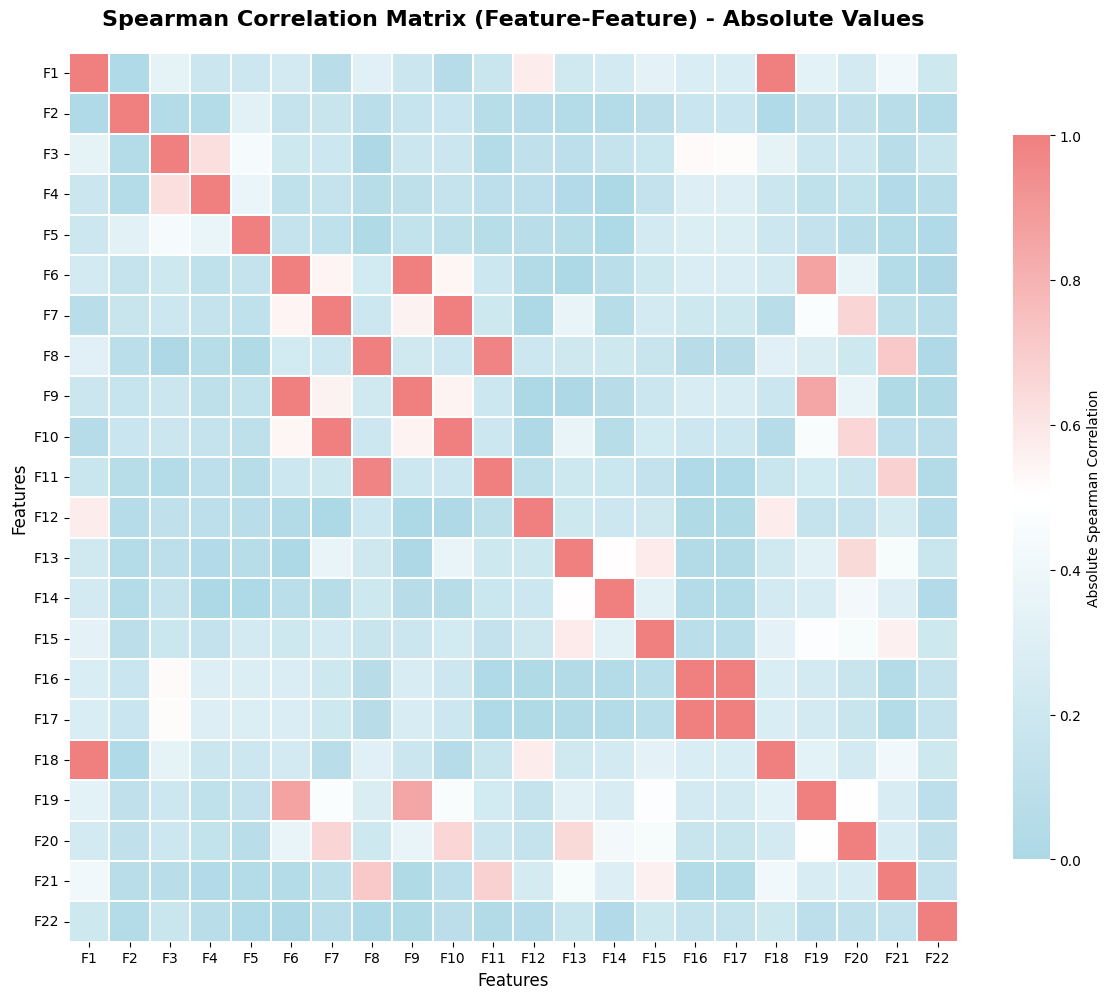

In [404]:
spearman_feature_corr = create_feature_spearman_analysis(X, features, figsize=(12, 10))

In [405]:
def create_mi_analysis(X, features, figsize=(14, 10), show_numerical=True, max_display_features=20):
    """
    Create a comprehensive mutual information analysis with numerical display and stylish heatmap
    
    Parameters:
    -----------
    X : DataFrame
        The input data containing the features
    features : list
        List of feature names to analyze
    figsize : tuple
        Figure size for the heatmap
    show_numerical : bool
        Whether to display the numerical DataFrame
    max_display_features : int
        Maximum number of features to show full names (otherwise use numbers)
    """
    
    print("Computing Mutual Information Matrix...")
    print("="*60)
    
    # --- Compute MI pairwise ---
    mi_matrix = pd.DataFrame(np.zeros((len(features), len(features))),
                           index=features, columns=features)
    
    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):
            if i < j:
                mask = X[[f1, f2]].dropna()
                if mask.shape[0] > 0:
                    mi = mutual_info_regression(mask[[f1]], mask[f2], random_state=0)[0]
                    mi_matrix.loc[f1, f2] = mi
                    mi_matrix.loc[f2, f1] = mi
    
    # Set diagonal to 0 (as specified)
    np.fill_diagonal(mi_matrix.values, 0)
    
    # --- Display numerical DataFrame ---
    if show_numerical:
        print("\nMutual Information Matrix (Numerical Values)")
        print("-" * 50)
        
        # Round values for cleaner display
        mi_display = mi_matrix.round(4)
        
        # Show top correlations
        print("\nTop 10 Feature Pairs by Mutual Information:")
        print("-" * 45)
        
        # Extract upper triangle values for ranking
        mask = np.triu(np.ones_like(mi_matrix, dtype=bool), k=1)
        mi_pairs = []
        
        for i in range(len(features)):
            for j in range(len(features)):
                if mask[i, j]:
                    mi_pairs.append((features[i], features[j], mi_matrix.iloc[i, j]))
        
        # Sort by MI value and display top 10
        mi_pairs_sorted = sorted(mi_pairs, key=lambda x: x[2], reverse=True)
        
        for idx, (f1, f2, mi_val) in enumerate(mi_pairs_sorted[:10], 1):
            print(f"{idx:2d}. {f1} ↔ {f2}: {mi_val:.4f}")
        
        print(f"\nMatrix Statistics:")
        print(f"   Mean MI: {mi_matrix.values[mask].mean():.4f}")
        print(f"   Max MI:  {mi_matrix.values[mask].max():.4f}")
        print(f"   Min MI:  {mi_matrix.values[mask].min():.4f}")
        print(f"   Std MI:  {mi_matrix.values[mask].std():.4f}")
    
    # --- Create stylish heatmap ---
    print(f"\nCreating Enhanced Heatmap Visualization...")
    
    # Determine if we should use feature numbering
    use_numbers = len(features) > max_display_features
    
    if use_numbers:
        # Create feature mapping
        feature_mapping = {feat: f"F{i+1}" for i, feat in enumerate(features)}
        print(f"\nFeature Mapping (showing numbers due to {len(features)} features):")
        print("-" * 40)
        for i, feat in enumerate(features):
            print(f"F{i+1:2d}: {feat}")
        
        # Create numbered version of matrix
        numbered_matrix = mi_matrix.copy()
        numbered_matrix.index = [f"F{i+1}" for i in range(len(features))]
        numbered_matrix.columns = [f"F{i+1}" for i in range(len(features))]
        plot_matrix = numbered_matrix
    else:
        plot_matrix = mi_matrix
    
    # Create the enhanced heatmap
    plt.figure(figsize=figsize)
    
    # Set up the vivid pastel color palette
    custom_cmap = sns.blend_palette(["lightblue", "white", "lightcoral"], as_cmap=True)
    
    # Create heatmap with enhanced styling
    ax = sns.heatmap(plot_matrix, 
                     cmap=custom_cmap,
                     annot=len(features) <= 15,  # Show values only for smaller matrices
                     fmt='.3f' if len(features) <= 15 else '.2f',
                     cbar_kws={
                         "shrink": 0.8, 
                         "aspect": 20,
                         "label": "Mutual Information Score"
                     },
                     square=True,
                     linewidths=0.1,
                     linecolor='white',
                     annot_kws={'size': 8 if len(features) <= 15 else 6})
    
    # Enhance the plot appearance
    plt.title("Mutual Information Matrix Between Features", 
              fontsize=16, fontweight='bold', pad=20)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right' if not use_numbers else 'center')
    plt.yticks(rotation=0)
    
    # Add subtle grid
    ax.set_facecolor('#f8f9fa')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    return mi_matrix

Computing Mutual Information Matrix...

Mutual Information Matrix (Numerical Values)
--------------------------------------------------

Top 10 Feature Pairs by Mutual Information:
---------------------------------------------
 1. depth_all ↔ price_impact_proxy_all: 4.5822
 2. microprice ↔ mid_price: 4.4179
 3. depth_top_5 ↔ liquidity_concentration_top_5: 3.5061
 4. depth_top_15 ↔ liquidity_concentration_top_15: 3.0450
 5. depth_top_50 ↔ liquidity_concentration_top_50: 1.9743
 6. depth_top_15 ↔ price_impact_proxy_top_15: 0.7549
 7. liquidity_concentration_top_15 ↔ price_impact_proxy_top_15: 0.7186
 8. depth_top_50 ↔ price_impact_proxy_top_50: 0.5898
 9. microprice ↔ volatility: 0.5627
10. mid_price ↔ volatility: 0.5611

Matrix Statistics:
   Mean MI: 0.1714
   Max MI:  4.5822
   Min MI:  0.0000
   Std MI:  0.5283

Creating Enhanced Heatmap Visualization...

Feature Mapping (showing numbers due to 22 features):
----------------------------------------
F 1: depth_all
F 2: depth_imbalance

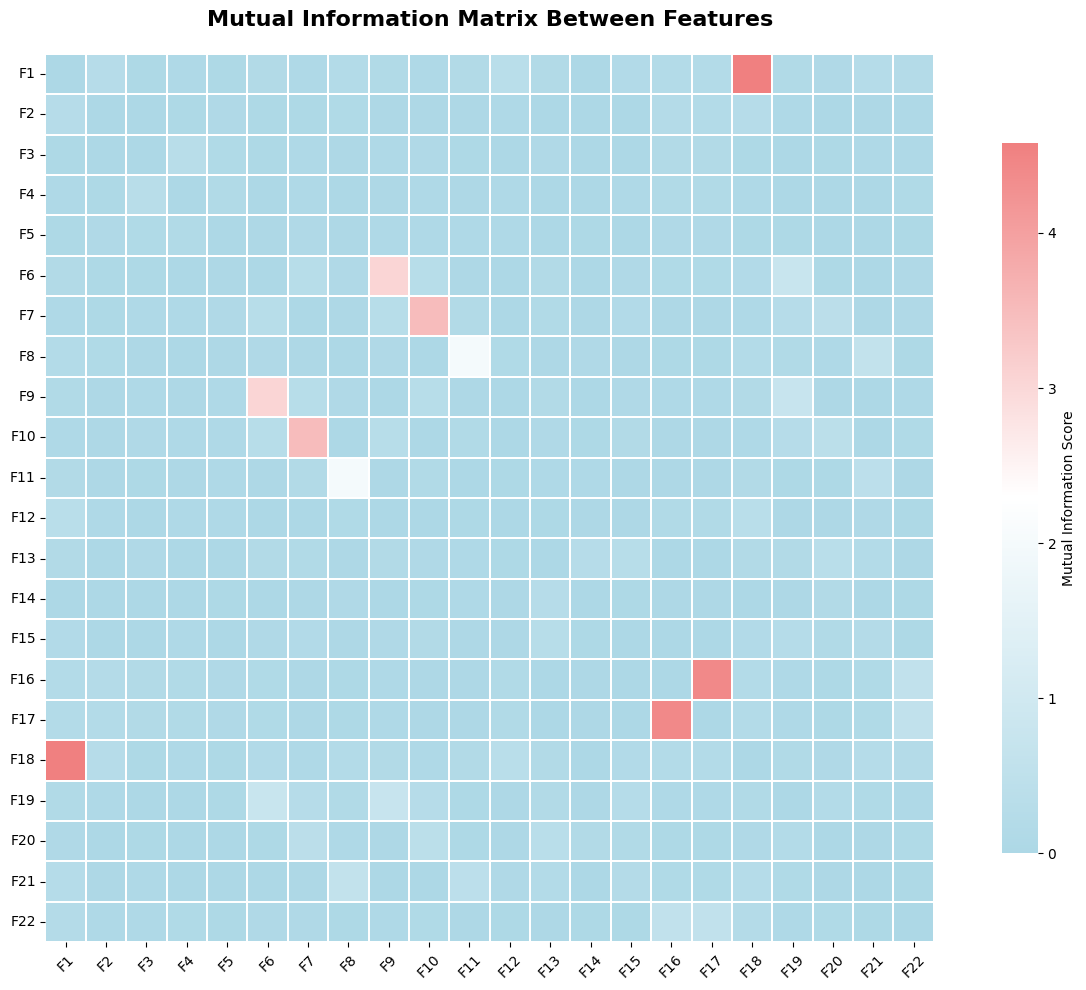

In [406]:
mi_result = create_mi_analysis(X, features, figsize=(14, 10))

In [407]:
def create_spearman_analysis(df, X, features, targets, figsize=(12, 10), show_numerical=True, max_display_features=25):
    """
    Create comprehensive Spearman correlation analysis between features and targets with numerical display and stylish heatmap
    
    Parameters:
    -----------
    df : DataFrame
        The full dataset containing both features and targets
    X : DataFrame
        The features data
    features : list
        List of feature names to analyze
    targets : list
        List of target names to analyze
    figsize : tuple
        Figure size for the heatmap
    show_numerical : bool
        Whether to display the numerical DataFrame
    max_display_features : int
        Maximum number of features to show full names (otherwise use numbers)
    """
    
    print("Computing Feature-Target Spearman Correlations...")
    print("="*60)
    
    # --- Spearman correlation (monotonic) ---
    print("Calculating Spearman correlations...")
    spearman_feat_tgt = pd.DataFrame(index=features, columns=targets)
    for tgt in targets:
        spearman_feat_tgt[tgt] = X.corrwith(df[tgt], method="spearman")
    
    # --- Display numerical analysis ---
    if show_numerical:
        print("\nSpearman Correlation Matrix (Feature-Target)")
        print("-" * 50)
        
        # Show statistics
        spearman_values = spearman_feat_tgt.values.flatten()
        spearman_values = spearman_values[~np.isnan(spearman_values)]
        
        print(f"\nSpearman Correlation Statistics:")
        print(f"   Mean:     {spearman_values.mean():.4f}")
        print(f"   Max:      {spearman_values.max():.4f}")
        print(f"   Min:      {spearman_values.min():.4f}")
        print(f"   Std:      {spearman_values.std():.4f}")
        print(f"   |Mean|:   {np.abs(spearman_values).mean():.4f}")
        
        # Show top correlations for Spearman
        print(f"\nTop 15 Feature-Target Pairs (by absolute value):")
        print("-" * 48)
        
        spearman_pairs = []
        for i, feat in enumerate(features):
            for j, tgt in enumerate(targets):
                val = spearman_feat_tgt.iloc[i, j]
                if not pd.isna(val):
                    spearman_pairs.append((feat, tgt, val, abs(val)))
        
        spearman_pairs_sorted = sorted(spearman_pairs, key=lambda x: x[3], reverse=True)
        
        for idx, (feat, tgt, corr_val, abs_val) in enumerate(spearman_pairs_sorted[:15], 1):
            print(f"{idx:2d}. {feat} → {tgt}: {corr_val:+.4f}")
    
    # --- Create heatmap ---
    print(f"\nCreating Enhanced Spearman Correlation Heatmap...")
    
    # Always use feature and target numbering
    # Create feature and target mappings
    print(f"\nFeature Mapping:")
    print("-" * 30)
    for i, feat in enumerate(features):
        print(f"F{i+1:2d}: {feat}")
    
    print(f"\nTarget Mapping:")
    print("-" * 25)
    for i, tgt in enumerate(targets):
        print(f"T{i+1:2d}: {tgt}")
    
    # Create numbered versions
    feature_labels = [f"F{i+1}" for i in range(len(features))]
    target_labels = [f"T{i+1}" for i in range(len(targets))]
    
    spearman_plot = spearman_feat_tgt.copy()
    spearman_plot.index = feature_labels
    spearman_plot.columns = target_labels
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Use absolute values for the heatmap
    spearman_abs = spearman_plot.abs()
    
    # Create vivid pastel blue-white-red palette
    custom_cmap = sns.blend_palette(["lightblue", "white", "lightcoral"], as_cmap=True)
    
    # Spearman correlation heatmap
    ax = sns.heatmap(spearman_abs, 
                     cmap=custom_cmap,
                     vmin=0, vmax=1,
                     annot=len(features) <= 15 and len(targets) <= 10,
                     fmt='.3f' if len(features) <= 15 else '.2f',
                     cbar_kws={
                         "shrink": 0.8, 
                         "aspect": 20,
                         "label": "Absolute Spearman Correlation"
                     },
                     linewidths=0.1,
                     linecolor='white',
                     square=True,
                     annot_kws={'size': 8 if len(features) <= 15 else 6})
    
    plt.title("Spearman Correlation Matrix (Features → Targets) - Absolute Values", 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Target Variables", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    # Add subtle styling
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()
    
    return spearman_feat_tgt

Computing Feature-Target Spearman Correlations...
Calculating Spearman correlations...

Spearman Correlation Matrix (Feature-Target)
--------------------------------------------------

Spearman Correlation Statistics:
   Mean:     0.0280
   Max:      0.3101
   Min:      -0.4091
   Std:      0.1309
   |Mean|:   0.1046

Top 15 Feature-Target Pairs (by absolute value):
------------------------------------------------
 1. mid_price → fwd_logret_120: -0.4091
 2. microprice → fwd_logret_120: -0.4087
 3. microprice → fwd_logret_60: -0.3887
 4. mid_price → fwd_logret_60: -0.3884
 5. microprice → fwd_logret_240: -0.3257
 6. mid_price → fwd_logret_240: -0.3253
 7. depth_imbalance_all → fwd_logret_240: -0.3135
 8. liquidity_spread_all → fwd_logret_40: +0.3101
 9. depth_all → fwd_logret_20: -0.3011
10. price_impact_proxy_all → fwd_logret_20: +0.3011
11. depth_all → fwd_logret_40: -0.2842
12. price_impact_proxy_all → fwd_logret_40: +0.2842
13. liquidity_spread_all → fwd_logret_20: +0.2707
14. micro

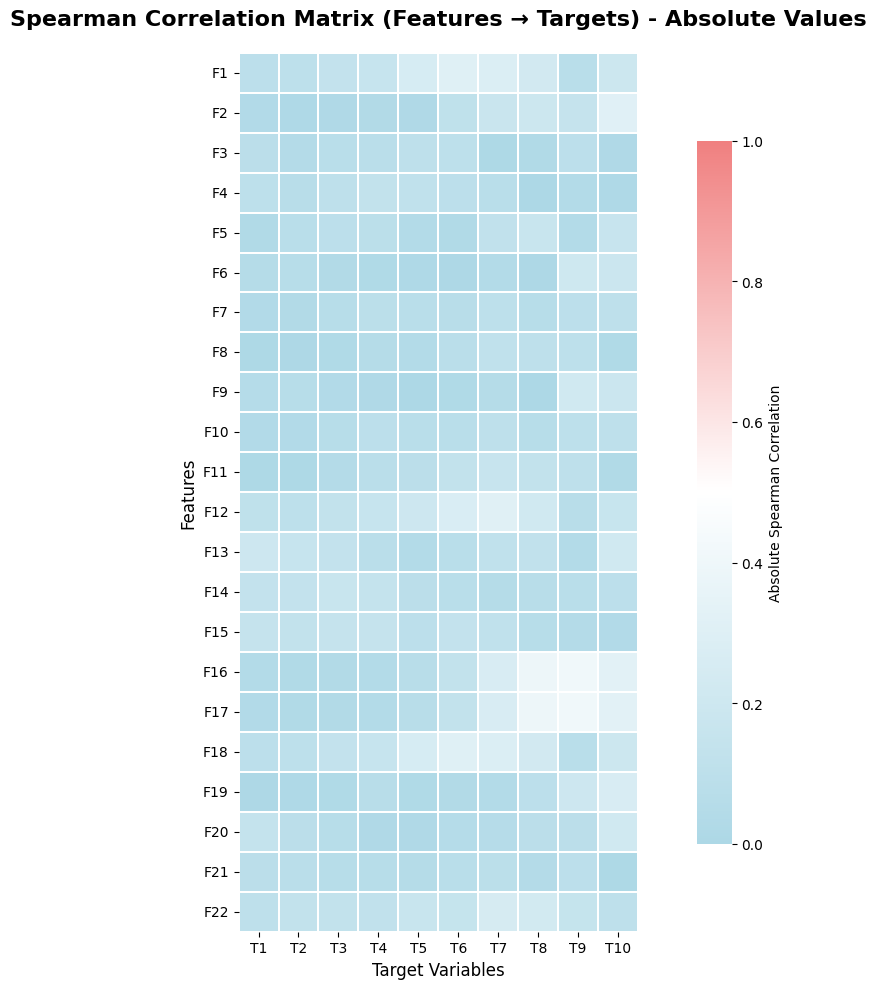

In [408]:
targets = ["fwd_logret_2","fwd_logret_3","fwd_logret_4","fwd_logret_5",
           "fwd_logret_10","fwd_logret_20","fwd_logret_40","fwd_logret_60",
           "fwd_logret_120","fwd_logret_240"]

spearman_corr = create_spearman_analysis(df, X, features, targets, figsize=(12, 10))

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

def create_mi_features_targets_analysis(df, X, features, targets, figsize=(12, 10), show_numerical=True, max_display_features=25):
    """
    Create comprehensive Mutual Information analysis between features and targets with numerical display and stylish heatmap
    
    Parameters:
    -----------
    df : DataFrame
        The full dataset containing both features and targets
    X : DataFrame
        The features data
    features : list
        List of feature names to analyze
    targets : list
        List of target names to analyze
    figsize : tuple
        Figure size for the heatmap
    show_numerical : bool
        Whether to display the numerical DataFrame
    max_display_features : int
        Maximum number of features to show full names (otherwise use numbers)
    """
    
    print("Computing Feature-Target Mutual Information...")
    print("="*60)
    
    # --- Compute MI between features and targets ---
    print("Calculating Mutual Information scores...")
    mi_feat_tgt = pd.DataFrame(index=features, columns=targets)
    
    for i, feat in enumerate(features):
        for j, tgt in enumerate(targets):
            # Get data with no missing values
            mask = df[[feat, tgt]].dropna()
            if mask.shape[0] > 0:
                mi = mutual_info_regression(mask[[feat]], mask[tgt], random_state=0)[0]
                mi_feat_tgt.loc[feat, tgt] = mi
            else:
                mi_feat_tgt.loc[feat, tgt] = 0
    
    # --- Display numerical analysis ---
    if show_numerical:
        print("\nMutual Information Matrix (Feature-Target)")
        print("-" * 50)
        
        # Show statistics
        mi_values = mi_feat_tgt.values.flatten()
        # Convert to float and handle any non-numeric values
        mi_values = pd.to_numeric(mi_values, errors='coerce')
        mi_values = mi_values[~np.isnan(mi_values)]
        
        print(f"\nMutual Information Statistics:")
        print(f"   Mean:     {mi_values.mean():.4f}")
        print(f"   Max:      {mi_values.max():.4f}")
        print(f"   Min:      {mi_values.min():.4f}")
        print(f"   Std:      {mi_values.std():.4f}")
        
        # Show top MI scores
        print(f"\nTop 15 Feature-Target Pairs (by MI score):")
        print("-" * 42)
        
        mi_pairs = []
        for i, feat in enumerate(features):
            for j, tgt in enumerate(targets):
                val = mi_feat_tgt.iloc[i, j]
                # Ensure the value is numeric
                if pd.notna(val) and pd.to_numeric(val, errors='coerce') is not None:
                    numeric_val = pd.to_numeric(val, errors='coerce')
                    mi_pairs.append((feat, tgt, numeric_val))
        
        mi_pairs_sorted = sorted(mi_pairs, key=lambda x: x[2], reverse=True)
        
        for idx, (feat, tgt, mi_val) in enumerate(mi_pairs_sorted[:15], 1):
            print(f"{idx:2d}. {feat} → {tgt}: {mi_val:.4f}")
    
    # --- Create heatmap ---
    print(f"\nCreating Enhanced Mutual Information Heatmap...")
    
    # Always use feature and target numbering
    # Create feature and target mappings
    print(f"\nFeature Mapping:")
    print("-" * 30)
    for i, feat in enumerate(features):
        print(f"F{i+1:2d}: {feat}")
    
    print(f"\nTarget Mapping:")
    print("-" * 25)
    for i, tgt in enumerate(targets):
        print(f"T{i+1:2d}: {tgt}")
    
    # Create numbered versions
    feature_labels = [f"F{i+1}" for i in range(len(features))]
    target_labels = [f"T{i+1}" for i in range(len(targets))]
    
    mi_plot = mi_feat_tgt.copy()
    mi_plot.index = feature_labels
    mi_plot.columns = target_labels
    
    # Convert to numeric format for plotting
    mi_plot = mi_plot.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Create vivid pastel blue-white-red palette
    custom_cmap = sns.blend_palette(["lightblue", "white", "lightcoral"], as_cmap=True)
    
    # Mutual Information heatmap
    ax = sns.heatmap(mi_plot, 
                     cmap=custom_cmap,
                     annot=len(features) <= 15 and len(targets) <= 10,
                     fmt='.3f' if len(features) <= 15 else '.2f',
                     cbar_kws={
                         "shrink": 0.8, 
                         "aspect": 20,
                         "label": "Mutual Information Score"
                     },
                     linewidths=0.1,
                     linecolor='white',
                     square=True,
                     annot_kws={'size': 8 if len(features) <= 15 else 6})
    
    plt.title("Mutual Information Matrix (Features → Targets)", 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Target Variables", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    # Add subtle styling
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()
    
    return mi_feat_tgt

Computing Feature-Target Mutual Information...
Calculating Mutual Information scores...

Mutual Information Matrix (Feature-Target)
--------------------------------------------------

Mutual Information Statistics:
   Mean:     0.0820
   Max:      0.6671
   Min:      0.0000
   Std:      0.1395

Top 15 Feature-Target Pairs (by MI score):
------------------------------------------
 1. microprice → fwd_logret_60: 0.6671
 2. mid_price → fwd_logret_60: 0.6667
 3. microprice → fwd_logret_240: 0.6186
 4. volatility → fwd_logret_60: 0.6175
 5. mid_price → fwd_logret_240: 0.6162
 6. mid_price → fwd_logret_40: 0.6150
 7. microprice → fwd_logret_40: 0.6140
 8. volatility → fwd_logret_240: 0.5620
 9. volatility → fwd_logret_120: 0.5395
10. mid_price → fwd_logret_120: 0.5346
11. microprice → fwd_logret_120: 0.5342
12. volatility → fwd_logret_40: 0.4508
13. mid_price → fwd_logret_20: 0.4468
14. microprice → fwd_logret_20: 0.4441
15. volatility → fwd_logret_20: 0.3353

Creating Enhanced Mutual Inform

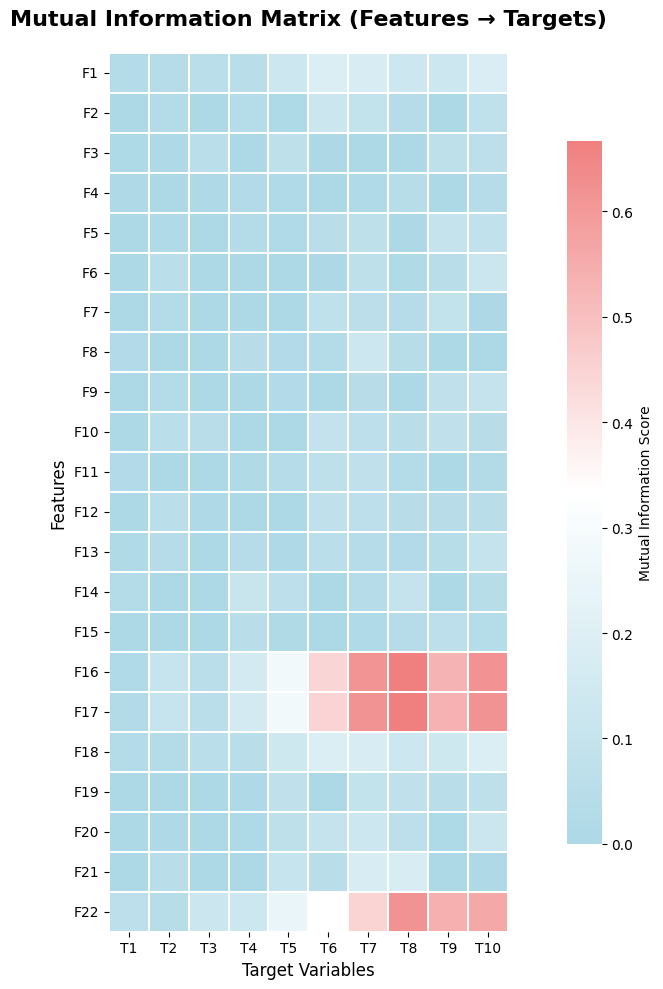

In [416]:
mi_feat_tgt = create_mi_features_targets_analysis(df, X, features, targets, figsize=(12, 10))